In [156]:
#For data:
import numpy as np
import pandas as pd
#For Web-scraping:
from bs4 import BeautifulSoup
import requests
#For counting things:
import re
from itertools import combinations, permutations
from collections import defaultdict
from collections import Counter
#For plotting:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

In [28]:
# Web scraping functions obtained from https://github.com/piocalderon/survivor-alliance-analysis
# with approval from Pio Calderon himself. - 6/15/2020

def turn_to_url(season):
    return 'http://survivor.wikia.com/wiki/Survivor:_' + season.replace(' ','_')

def process(string):
    stripped = string.strip()
    return re.sub('[0-9]+', '', stripped)
    
def extract_voting_table_as_df(link):
#         Extract the voting history table as a pandas data frame.
#         Input: link - url for the season page in Survivor wiki
#         Output: dd - pandas dataframe of the voting history table
    cara = requests.get(link)
    soup = BeautifulSoup(cara.content, 'lxml')
        
    # use select() bec 2 css classes
    voting_table = soup.select('table.wikitable.article-table')[-1]
    # obtain the table cells of the voters (the leftmost column)
    names = voting_table.find_all('td', style = 'text-align: left;')
    names.extend(voting_table.find_all('td', style = 'text-align: left; white-space: nowrap;'))
    # obtain the names of the voters as strings
    contestants = []
    for voter in names:
        contestants.append(process(voter.text))
    #print(contestants)
    
    no_vote = ['Quit', 'Evacuated']
    # we will convert this list into a pandas df
    season_list = []
    for voter in names:
        voter_dict = {'Name' : process(voter.text)}
        inc = 0
        for voted in voter.find_next_siblings():
            if process(voted.text) in ['Jury Vote','']:
                break
            # some cell span more than one column
            # compensate for this by adding more '—'
            if voted.has_attr('colspan'):
                numcol = int(voted['colspan'])
                for i in range(numcol):
                    voter_dict[inc] = '—'
                    inc += 1
                continue
            if (process(voted.text) in contestants) or (process(voted.text) == '—') or (process(voted.text) in no_vote):
                voter_dict[inc] = process(voted.text)
            inc += 1
        season_list.append(voter_dict)
    #print(season_list)
    
    # convert the list into a pd data frame and set as index the voters
    dd = pd.DataFrame(season_list).set_index('Name')
    # rearrange the columns of the data frame in increasing order
    dd = dd[sorted(dd.columns)]
    
    # remove columns which represent no voting: evacuated or quit
    del_cols = []
    for i in dd.columns:
        #print(dd[i].values)
        if ('Evacuated' in dd[i].values) or ('Quit' in dd[i].values):
            del_cols.append(i)
            continue
        for ind,j in enumerate(dd[i].values):
            if j in contestants:
                break
            if ind==len(dd[i])-1:
                del_cols.append(i)
    #print(del_cols)
    dd=dd.drop(del_cols,axis=1)
    return dd

In [36]:
#obtained from https://survivor.fandom.com/wiki/Main_Page

seasons_list=['Borneo', 'The Australian Outback', 'Africa','Marquesas','Thailand', 
              'The Amazon', 'Pearl Islands','All-Stars','Vanuatu','Palau',
              'Guatemala','Panama','Cook Islands','Fiji','China',
              'Micronesia','Gabon','Tocantins','Samoa','Heroes vs. Villains',
              'Nicaragua','Redemption Island','South Pacific','One World','Philippines',
              'Caramoan','Blood vs. Water','Cagayan','San Juan del Sur','Worlds Apart',
              'Cambodia','Kaôh Rōng','Millennials vs. Gen X','Game Changers','Heroes vs. Healers vs. Hustlers',
              'Ghost Island','David vs. Goliath','Edge of Extinction','Island of the Idols','Winners at War']
print(len(seasons_list))

40


In [68]:
#get the data for all of the seasons recursively from https://survivor.fandom.com/wiki/Survivor+________
seasons_data={}
#create a dictionary of dataframes
for i in range(len(seasons_list)):
    seasons_data[i+1]=extract_voting_table_as_df(turn_to_url(seasons_list[i]))
#     seasons_data[i+1].info()

In [464]:
def convert_to_adj_matrix(df, weighted=True):
    players=len(df)
    adj_mat=np.zeros(shape=(players, players))
#     nans_dct={}
#     for i in range(players):
#         nans_dct[i]=int(df.iloc[[i]].isnull().sum(axis = 1))

    for i in range(players):
        for j in range(i):
            if i !=j:
                count=0
                list1=list(df.iloc[[i]].values[0])
                list2=list(df.iloc[[j]].values[0])
                for k in range(len(df.iloc[[i]].values[0])):
                    if ( list1[k] != 'nan' ) or ( list2[k] != 'nan' ): 
                        # Don't count if there was no vote for either individuals
                        if ( list1[k] != '—' ) and ( list2[k] != '—' ): 
                             # Don't count if there was no vote for these two individuals
                            if list1[k] == list2[k]:
                                #Count only if they agree (includes nans)
                                if weighted==True:
                                    count+=1
                                else:
                                    adj_mat[i,j]=1
                if weighted==True:
                    adj_mat[i,j]=count
    adj_mat=adj_mat+np.transpose(adj_mat)
    return adj_mat

def clean_df(df, mat_df):
    mat_df.columns=list(df.index)
    mat_df.index=list(df.index)
    for k in reversed(range(len(mat_df))):
        if "Notes" in  mat_df.index[k]:
            mat_df.drop(mat_df.index[k], inplace=True, axis=1)
            mat_df.drop(mat_df.index[k], inplace=True, axis=0)
    return mat_df

def shuffle_df(df):
    cols=df.columns
    df=df.sample(frac=1)
    df=df.sample(frac=1, axis=1)#.reset_index(drop=True)
    return df

In [385]:
adj1=convert_to_adj_matrix(seasons_data[1])

adj1_df=pd.DataFrame(adj1)
adj1_df=clean_df(seasons_data[1], adj1_df)
adj1_df=shuffle_df(adj1_df)
adj1=adj1[0:-1, 0:-1]
adj1_df.head(18)

,B.B.,Gretchen,Greg,Joel,Gervase,Colleen,Ramona,Kelly,Rudy,Dirk,Susan,Jenna,Richard,Sonja,Stacey,Sean
Joel,0.0,2.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
Gretchen,0.0,0.0,1.0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
Kelly,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,6.0,1.0,5.0,1.0,2.0,2.0
Colleen,0.0,3.0,2.0,2.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
Susan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,9.0,2.0,0.0,1.0,8.0,0.0,0.0,6.0
B.B.,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Greg,1.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Stacey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Dirk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0
Sonja,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [318]:
adj1_df.index[15]

'Sonja'

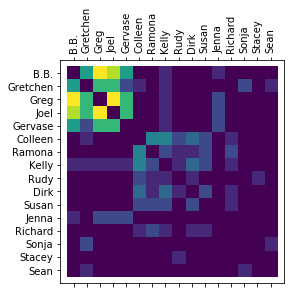

In [386]:
plt.matshow(adj1)
plt.xticks(ticks=np.linspace(0,len(adj1)-1,len(adj1)), labels=list(adj1_df.columns), rotation='90')
plt.yticks(ticks=np.linspace(0,len(adj1)-1,len(adj1)), labels=list(adj1_df.columns))
plt.xlim([-1, len(adj1)])
plt.ylim([len(adj1), -1] )
plt.show()

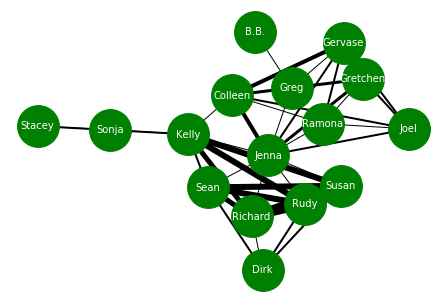

In [388]:
H=nx.from_pandas_adjacency(adj1_df)
pos=nx.kamada_kawai_layout(H)

edges = H.edges()
weights=[H[u][v]['weight'] for u,v in edges]
nx.draw(H, pos, edges=edges, width=weights, with_labels=True, node_size=1750, node_color='g', font_size='10', font_color='w')


In [466]:
def get_graph(df,shuffle=False, weighted=True):
    adj_mat=convert_to_adj_matrix(df, weighted=weighted)
    adj_df=pd.DataFrame(adj_mat)
    adj_df=clean_df(df, adj_df)
    if shuffle==True:
        adj_df=shuffle_df(adj_df)
    Q=nx.from_pandas_adjacency(adj_df)
    return Q

def plot_season(df, layout='kamada_kawai', shuffle=False, weighted=True):
    
    Q=get_graph(df,shuffle=shuffle, weighted=weighted)
    plt.figure(figsize=(7,7))
    if layout=='circular':
        pos=nx.circular_layout(Q, scale=1.60, center=[0,0])
    elif layout=='spring':
        pos=nx.spring_layout(Q)
    else:
        pos=nx.kamada_kawai_layout(Q)

    edges = Q.edges()
    weights=[Q[u][v]['weight'] for u,v in edges]
    nx.draw(Q, pos, edges=edges, width=weights, with_labels=True, node_size=1750, node_color='g', font_size='10', font_color='w')


In [467]:
nums=[1,3,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
prime_seasons={}
for k in nums:
    prime_seasons[k]=seasons_data[k]

Season 1 : Borneo


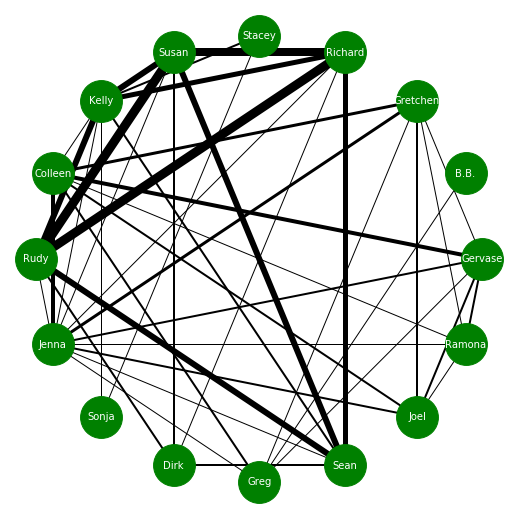

Season 3 : Africa


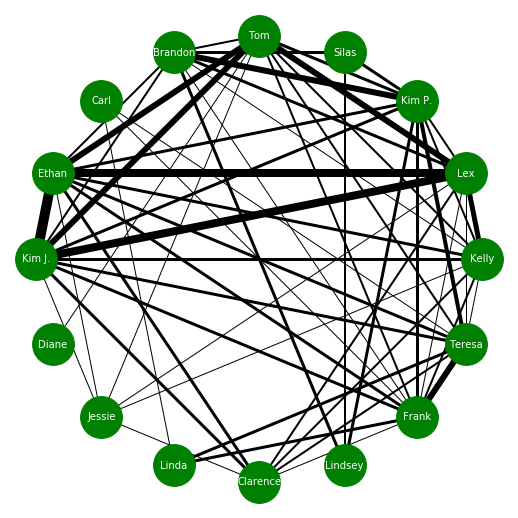

Season 12 : Panama


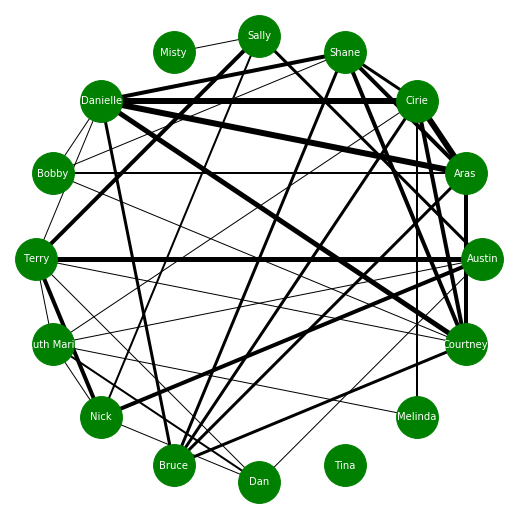

Season 13 : Cook Islands


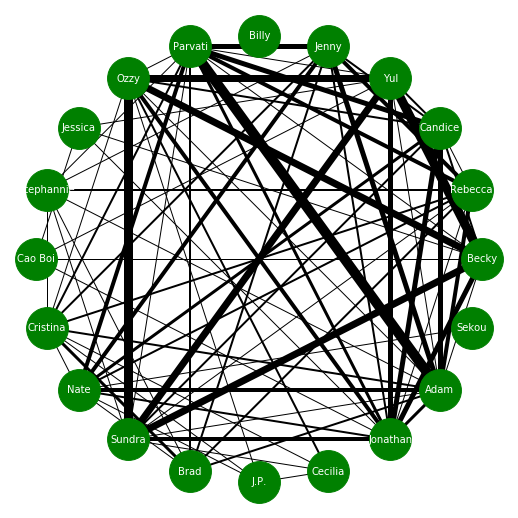

Season 14 : Fiji


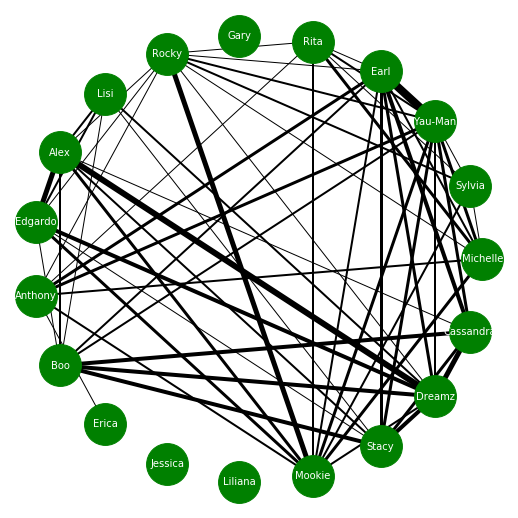

Season 15 : China


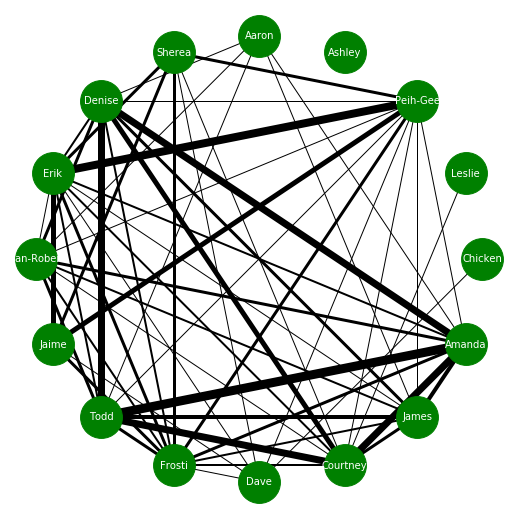

Season 16 : Micronesia


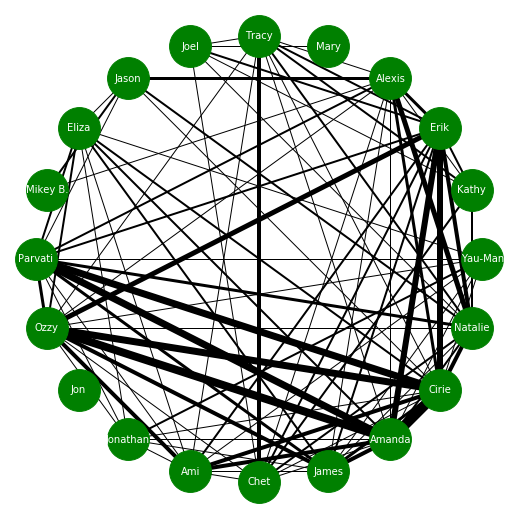

Season 17 : Gabon


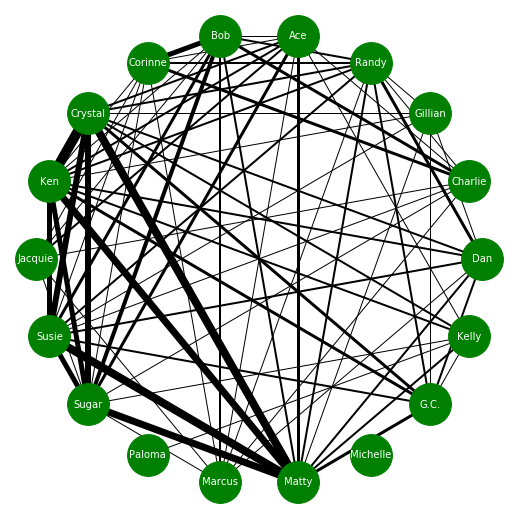

Season 18 : Tocantins


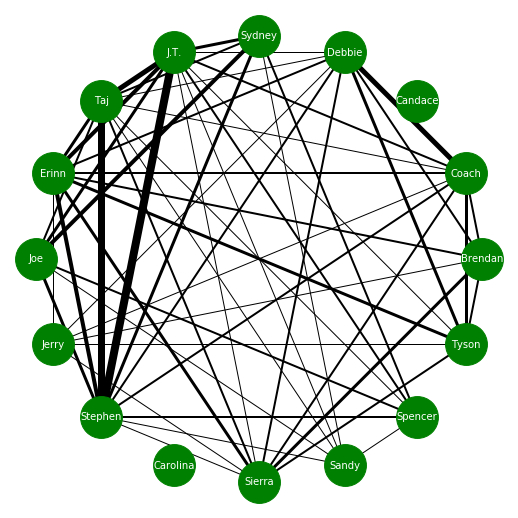

Season 19 : Samoa


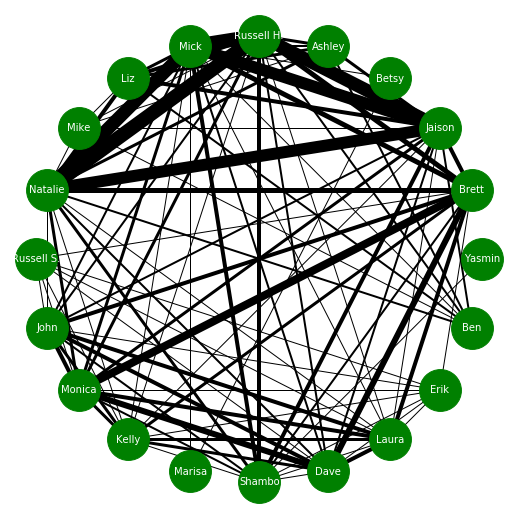

Season 20 : Heroes vs. Villains


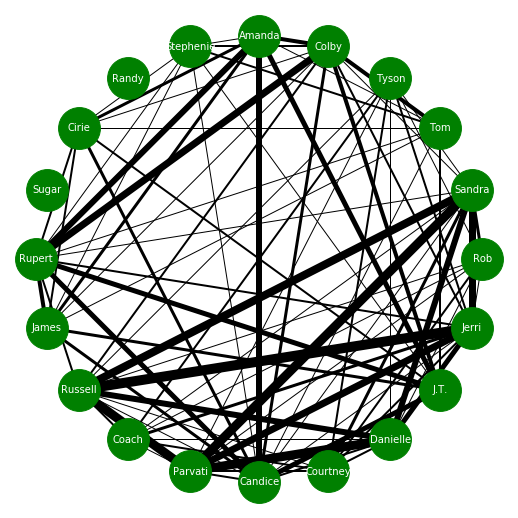

Season 21 : Nicaragua


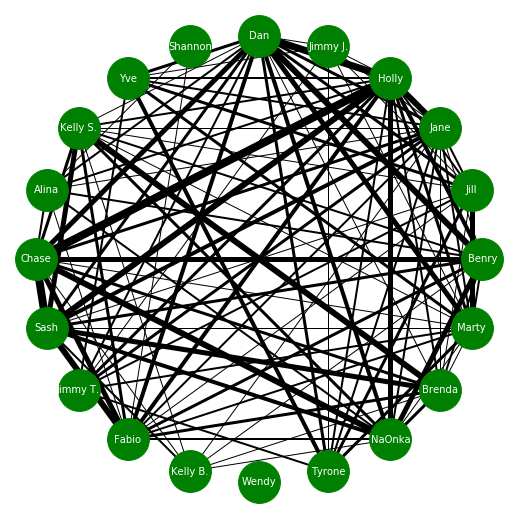

Season 22 : Redemption Island


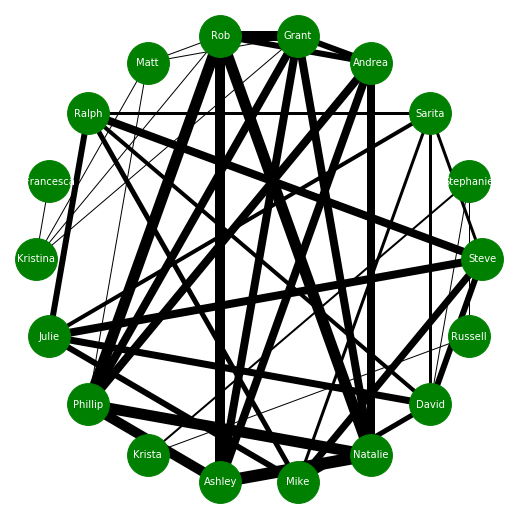

Season 23 : South Pacific


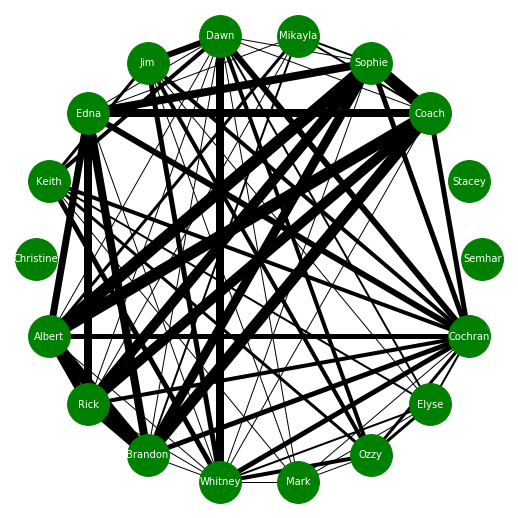

Season 24 : One World


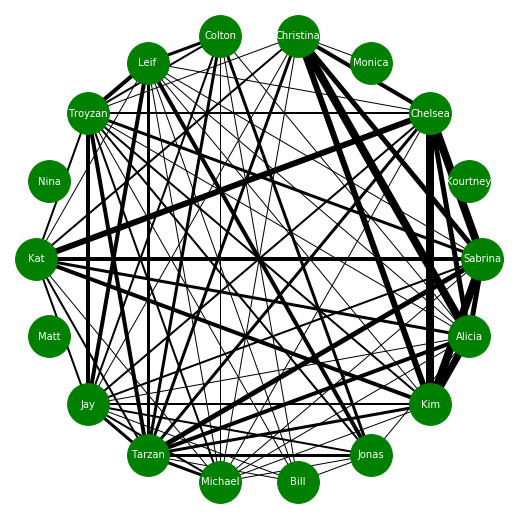

Season 25 : Philippines


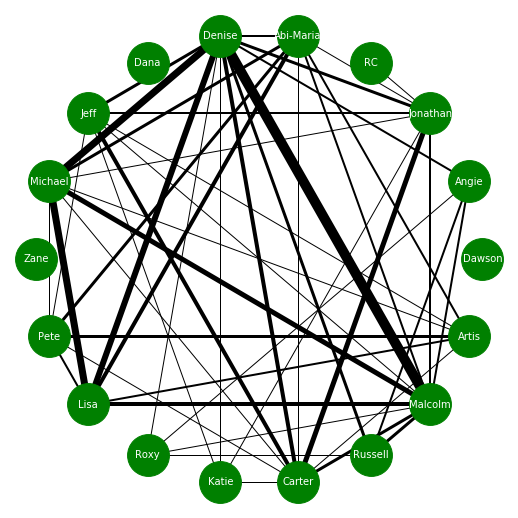

Season 26 : Caramoan


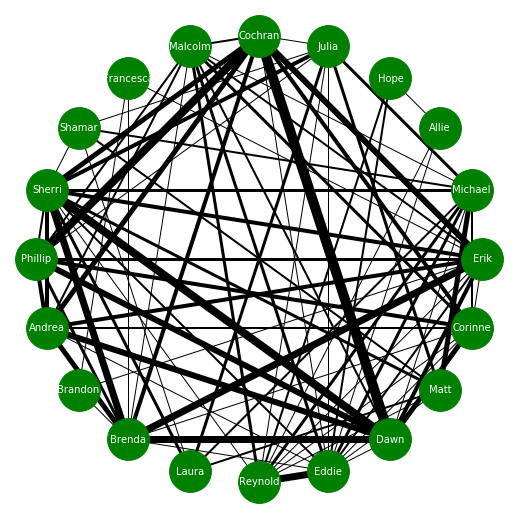

Season 27 : Blood vs. Water


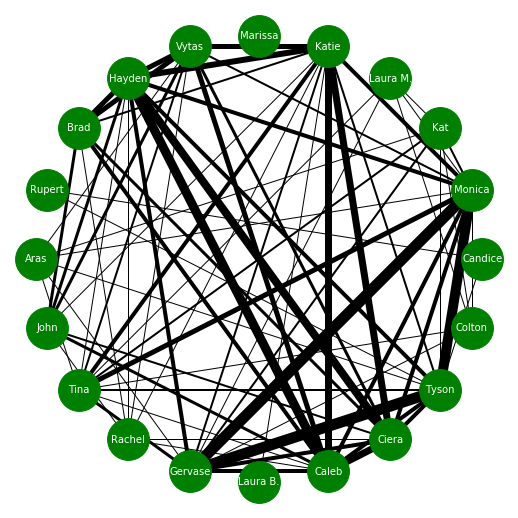

Season 28 : Cagayan


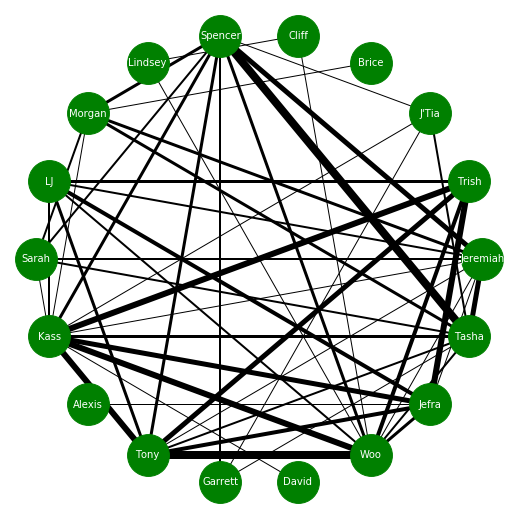

In [399]:
graphs={}
for i in nums:
    print('Season '+str(i)+' : '+seasons_list[i-1])
    plot_season(prime_seasons[i], layout='circular', shuffle=True)
    plt.show()


In [468]:
for i in range(len(seasons_list)):
    graphs[i+1]=get_graph(seasons_data[i+1], shuffle=True,weighted=False)


In [469]:
cluster = []
deg=[]
av_deg = []
av_closeness = []
av_between = []
# wav_deg = []
# wav_closeness = []
# wav_between = []
max_deg = []
max_closeness = []
max_between = []
# wmax_deg = []
# wmax_closeness = []
# wmax_between = []
max_cluster = []

for i in range(len(graphs)):
    cluster.append(nx.average_clustering(graphs[i+1]))
    max_cluster.append(np.max(list(nx.clustering(graphs[i+1]).values())))
    av_deg.append(np.mean(list(nx.degree_centrality(graphs[i+1]).values())))
    av_closeness.append(np.mean(list(nx.closeness_centrality(graphs[i+1]).values())))
    av_between.append(np.mean(list(nx.betweenness_centrality(graphs[i+1]).values())))
    max_deg.append(np.max(list(nx.degree_centrality(graphs[i+1]).values())))
    max_closeness.append(np.max(list(nx.closeness_centrality(graphs[i+1]).values())))
    max_between.append(np.max(list(nx.betweenness_centrality(graphs[i+1]).values())))
    deg.append(np.mean(list(dict(nx.degree(graphs[i+1], weight = 'weight')).values())))
#     wav_deg.append(np.mean(list(dict(nx.degree(graphs[i], weight = 'weight')).values()))/((len(graphs[i].nodes()))-1))
#     wav_closeness.append(np.mean(list(dict(nx.closeness_centrality(graphs[i], distance = 'weight')).values())))
#     wav_between.append(np.mean(list(dict(nx.betweenness_centrality(graphs[i], weight = 'weight')).values())))
#     wmax_deg.append(np.max(list(dict(nx.degree(graphs[i], weight = 'weight')).values()))/((len(graphs[i].nodes()))-1))
#     wmax_closeness.append(np.max(list(dict(nx.closeness_centrality(graphs[i], distance = 'weight')).values())))
#     wmax_between.append(np.max(list(dict(nx.betweenness_centrality(graphs[i], weight = 'weight')).values())))

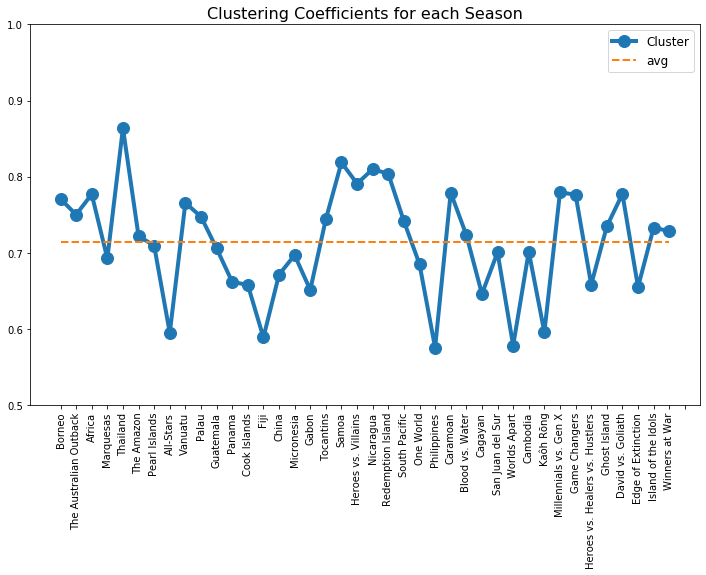

In [470]:
plt.figure(figsize=(12,7))
plt.plot(cluster, 'o-', label='Cluster', markersize='12', linewidth=4)
plt.plot(np.mean(cluster)*np.ones(40),'--', label='avg',linewidth=2)
plt.xticks(np.linspace(0,40,41),seasons_list,rotation='90')
plt.ylim([0.5,1])
plt.legend(loc='best', fontsize=12)
plt.title('Clustering Coefficients for each Season', fontsize=16)
plt.show()

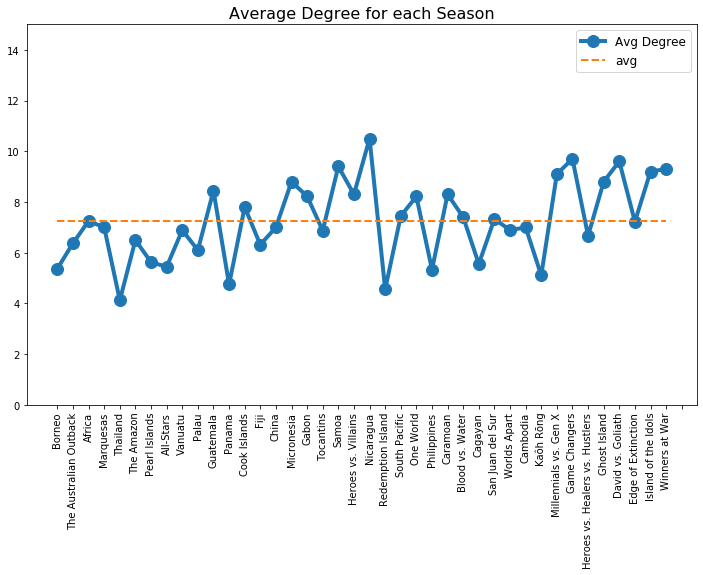

In [472]:
plt.figure(figsize=(12,7))
plt.plot(deg, 'o-', label='Avg Degree', markersize='12', linewidth=4)
plt.plot(np.mean(deg)*np.ones(40),'--', label='avg',linewidth=2)
plt.xticks(np.linspace(0,40,41),seasons_list,rotation='90')
plt.legend(loc='best', fontsize=12)
plt.title('Average Degree for each Season', fontsize=16)
plt.ylim([0,15])
plt.show()